In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_212828/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-27 12:21:01.098419: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 12:21:01.136456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 12:21

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

#data_all=hf.add_MSI_noise(data_all,channel_labels)

In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels_one=['Clear_B12']
y_labels_all=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=data_all.copy()
#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)


X=df[X_labels]
y_all=df[y_labels_all]
y_one=df[y_labels_one]

X_train, X_test, y_train_all, y_test_all=train_test_split(X,y_all,test_size=0.05)

indexes_training_data=y_train_all.index
indexes_test_data=y_test_all.index

y_train_one=y_one.iloc[indexes_training_data]
y_test_one=y_one.iloc[indexes_test_data]



In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]


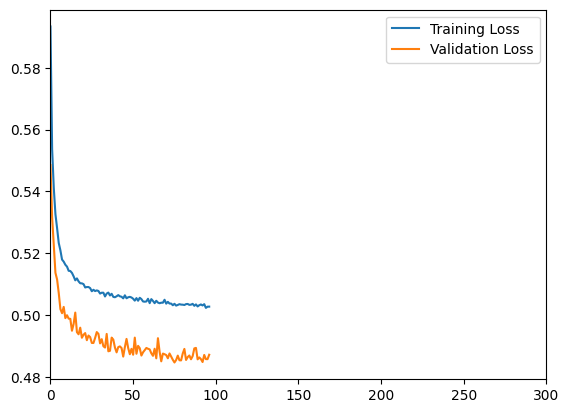

In [6]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=False

nepochs=300
model_all=QuantileNetwork(quantiles=quantiles)
model_one=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes_all=128
sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_all),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all, len(quantiles)*len(y_labels_all)) #Output dimesion is number of quantiles times number of target variables
)
n_nodes_one=64
sequence_one=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels_one)) #Output dimesion is number of quantiles times number of target variables
)

model_all.fit(X_train.to_numpy(),y_train_all.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_all(),
          lr=0.003,
          data_norm=True,
          decay=False,
          decay_gamma=0.5,
          decay_wait=5,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_estimate_1_v_all_channels/all',model=model_all,X_test=X_test,y_test=y_test_all)
    print("Model all saved...")

model_one.fit(X_train.to_numpy(),y_train_one.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_one(),
          lr=0.003,
          data_norm=True,
          decay=False,
          decay_gamma=0.5,
          decay_wait=5,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_estimate_1_v_all_channels/one',model=model_one,X_test=X_test,y_test=y_test_one)
    print("Model on saved...")


## Load trained models and Visualise

In [73]:
#Load models
model_all,X_test,y_test_all=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/all')
model_one,X_test,y_test_one=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/one')


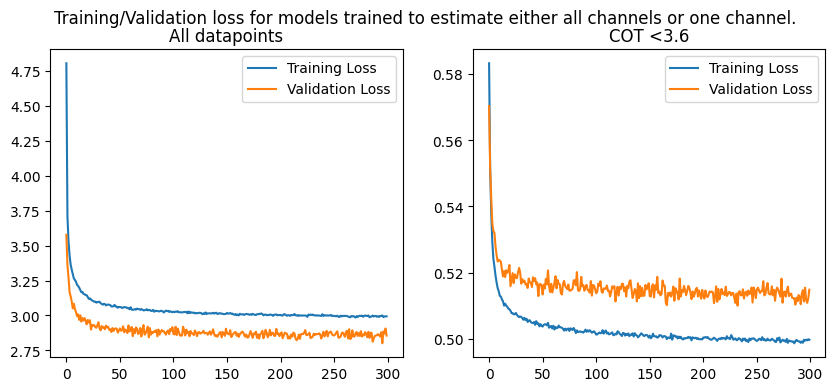

In [97]:
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Training/Validation loss for models trained to estimate either all channels or one channel.")

ax[0].plot(model_all.train_loss.data.cpu().numpy())
ax[0].plot(model_all.val_loss.data.cpu().numpy())
ax[0].set_title("All datapoints")
ax[0].legend(['Training Loss','Validation Loss'])

ax[1].plot(model_one.train_loss.data.cpu().numpy())
ax[1].plot(model_one.val_loss.data.cpu().numpy())
ax[1].set_title("COT <3.6")
ax[1].legend(['Training Loss','Validation Loss'])

In [113]:
cot_limit=True
cot_limit_val=3.6
if cot_limit:
    df_test=df.iloc[X_test.index]
    X_test=df_test[df_test['COT']<cot_limit_val][X_labels]
    indexes=X_test.index
    y_test_all=df.iloc[indexes][y_labels_all]
    y_test_one=df.iloc[indexes][y_labels_one]

In [114]:
#Make predictions
y_preds_all=model_all.predict(X_test.to_numpy())
y_preds_all_11=y_preds_all[:,10,:]
y_preds_one=model_one.predict(X_test.to_numpy())
y_preds_one=y_preds_one[:,0,:]



In [115]:
## Calculate residuals
y_all=y_test_all.to_numpy()[:,10]
res_all=y_all-y_preds_all_11[:,1]

y_one=y_test_one.to_numpy()[:,0]
res_one=y_one-y_preds_one[:,1]

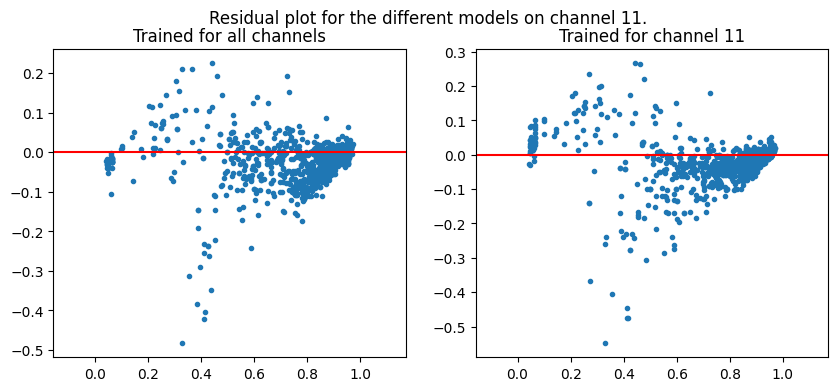

In [116]:
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plot for the different models on channel 11.")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Trained for all channels")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_one,res_one,'.')
ax[1].set_title("Trained for channel 11")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_one)-0.2,np.max(y_one)+0.2))

plt.show()


In [117]:
r2_all=r2_score(y_all,y_preds_all_11[:,1])
r2_one=r2_score(y_one,y_preds_one[:,1])
mse_all=mean_squared_error(y_all,y_preds_all_11[:,1])
mse_one=mean_squared_error(y_one,y_preds_one[:,1])

print("R2 score channel 11, model trained for all channels: "+str(r2_all))
print("R2 score channel 11, model trained for channel 11: "+str(r2_one))
print(" ")
print("MSE score channel 11, model trained for all channels: "+str(mse_all))
print("MSE score channel 11, model trained for channel 11: "+str(mse_one))


R2 score channel 11, model trained for all channels: 0.9295087111102178
R2 score channel 11, model trained for channel 11: 0.9104208460611148
 
MSE score channel 11, model trained for all channels: 0.002541842797576427
MSE score channel 11, model trained for channel 11: 0.003230131422459352
